In [57]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from torch import nn # nn contains all of PyTorch's building blocks for neural networks
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from helper_functions import plot_predictions, plot_decision_boundary

device = "cuda" if torch.cuda.is_available() else "cpu"

# Check PyTorch version
torch.__version__, device

('2.2.2+cu121', 'cuda')

In [58]:
X, y = make_circles(1000, random_state=42)

data = pd.concat(
  [
    pd.DataFrame(X),
    pd.DataFrame(y, columns=['target'])
  ],
  axis=1
)

X = torch.Tensor(X)
y = torch.Tensor(y)

print(data.shape)
data.head(3)

(1000, 3)


,0,1,target
0,0.772305,0.208673,1
1,-0.789349,0.130110,1
2,-0.793692,0.100267,1


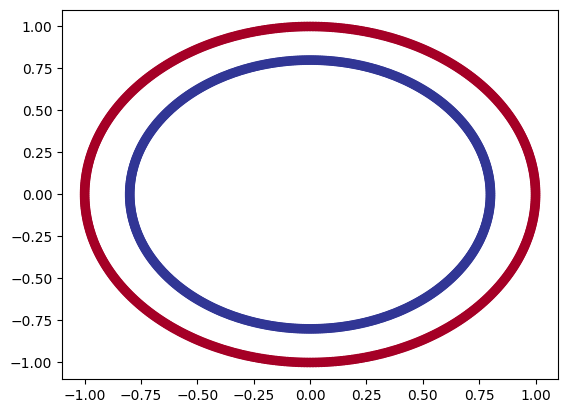

In [59]:
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu);

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [61]:
# Build model
class MyModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=50),
            nn.PReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=50, out_features=output_features), # how many classes are there?
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = MyModel(input_features=2, 
                    output_features=1).to(device)
model_4

MyModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=50, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)

In [62]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_4.parameters(), 
                            lr=0.1)

In [63]:
model_4(X_train.to(device))[:5]

tensor([[0.2993],
        [0.2480],
        [0.2752],
        [0.2747],
        [0.2471]], device='cuda:0', grad_fn=<SliceBackward0>)

In [64]:
# Make prediction logits with model
y_logits = model_4(X_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1) 
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[0.2285],
        [0.2036],
        [0.2043],
        [0.2998],
        [0.2320]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0', grad_fn=<SliceBackward0>)


In [65]:
# Checking total sums
print(y_pred_probs[:5].sum(dim=1))

tensor([1., 1., 1., 1., 1.], device='cuda:0', grad_fn=<SumBackward1>)


In [66]:
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([1.], device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0, device='cuda:0')


In [67]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [68]:
loss_fn = nn.BCEWithLogitsLoss()

In [69]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

all_test_loss = []
all_train_loss = []
all_epochs = []

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_train) # model outputs raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits.reshape(shape=(800,)), y_train) 
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits.reshape(shape=(200,)), y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")
        all_test_loss.append(test_loss.cpu().detach().numpy())
        all_train_loss.append(loss.cpu().detach().numpy())
        all_epochs.append(epoch)

Epoch: 0 | Loss: 0.70154, Acc: 49.38% | Test Loss: 0.74344, Test Acc: 52.50%
Epoch: 10 | Loss: 0.67360, Acc: 49.38% | Test Loss: 0.66016, Test Acc: 52.50%
Epoch: 20 | Loss: 0.50746, Acc: 49.38% | Test Loss: 0.45998, Test Acc: 52.50%
Epoch: 30 | Loss: 0.21343, Acc: 49.38% | Test Loss: 0.35556, Test Acc: 52.50%
Epoch: 40 | Loss: 0.11754, Acc: 49.38% | Test Loss: 0.08174, Test Acc: 52.50%
Epoch: 50 | Loss: 0.02743, Acc: 49.38% | Test Loss: 0.02837, Test Acc: 52.50%
Epoch: 60 | Loss: 0.00704, Acc: 49.38% | Test Loss: 0.01038, Test Acc: 52.50%
Epoch: 70 | Loss: 0.00286, Acc: 49.38% | Test Loss: 0.00367, Test Acc: 52.50%
Epoch: 80 | Loss: 0.00158, Acc: 49.38% | Test Loss: 0.00185, Test Acc: 52.50%
Epoch: 90 | Loss: 0.00108, Acc: 49.38% | Test Loss: 0.00131, Test Acc: 52.50%
Epoch: 100 | Loss: 0.00088, Acc: 49.38% | Test Loss: 0.00112, Test Acc: 52.50%
Epoch: 110 | Loss: 0.00074, Acc: 49.38% | Test Loss: 0.00092, Test Acc: 52.50%
Epoch: 120 | Loss: 0.00064, Acc: 49.38% | Test Loss: 0.00080, T

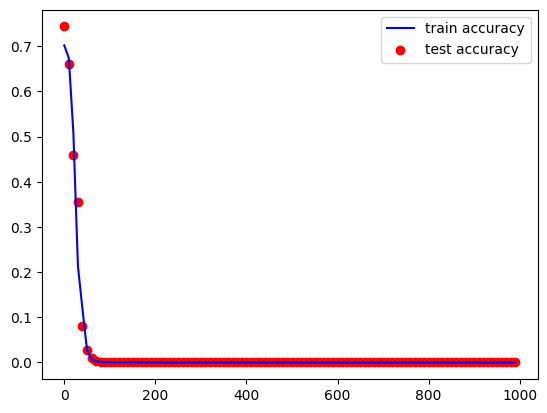

In [70]:
plt.plot(np.arange(0, 1000, 10), np.array(all_train_loss), c='b', label='train accuracy')
plt.scatter(np.arange(0, 1000, 10), np.array(all_test_loss), c='r', label='test accuracy')
plt.legend()
plt.show()

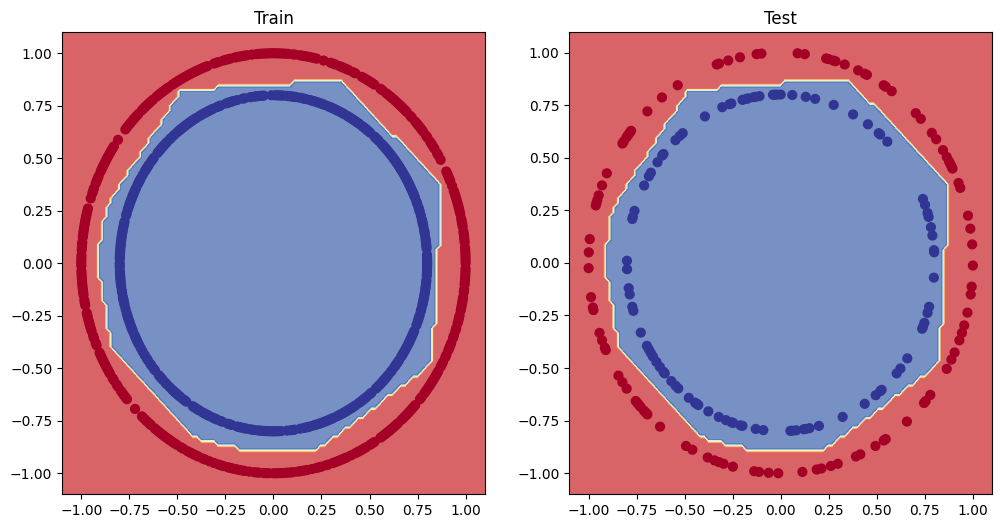

In [71]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_test, y_test)

### Multiclassification

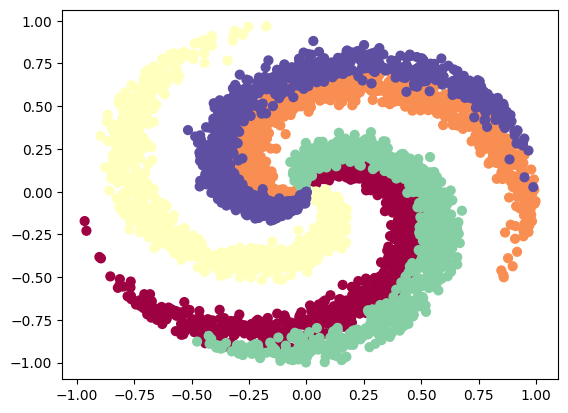

In [89]:
# Code for creating a spiral dataset from CS231n
import numpy as np
N = 1000 # number of points per class
D = 2 # dimensionality
K = 5 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

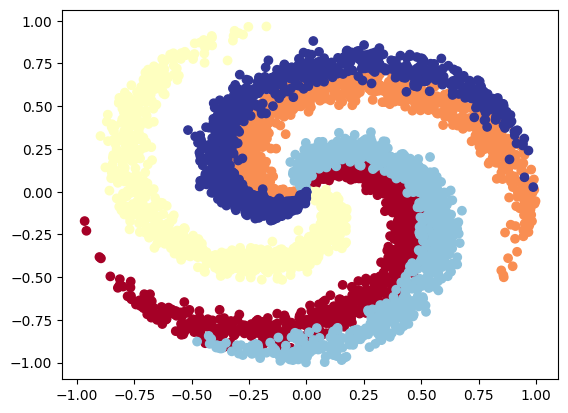

In [90]:
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu);

In [91]:
X = torch.Tensor(X)
y = torch.Tensor(y)

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [93]:
# Build model
class MyModel(nn.Module):
    def __init__(self):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=2, out_features=7),
            nn.Linear(in_features=7, out_features=7),
            nn.Linear(in_features=7, out_features=7),
            nn.Linear(in_features=7, out_features=7),
            nn.PReLU(),
            nn.Linear(in_features=7, out_features=7),
            nn.Tanh(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=7, out_features=5), # how many classes are there?
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_5 = MyModel().to(device)
model_5

MyModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=7, bias=True)
    (1): Linear(in_features=7, out_features=7, bias=True)
    (2): Linear(in_features=7, out_features=7, bias=True)
    (3): Linear(in_features=7, out_features=7, bias=True)
    (4): PReLU(num_parameters=1)
    (5): Linear(in_features=7, out_features=7, bias=True)
    (6): Tanh()
    (7): Linear(in_features=7, out_features=5, bias=True)
  )
)

In [94]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_5.parameters(), 
                            lr=0.005)

In [95]:
X_test.shape

torch.Size([1000, 2])

In [96]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [97]:
y_train = y_train.to(torch.long)
y_test = y_test.to(torch.long)

In [98]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 5000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

all_test_loss = []
all_train_loss = []
all_epochs = []

for epoch in range(epochs):
    ### Training
    model_5.train()

    # 1. Forward pass
    X_train = X_train.to(torch.float32)
    y_logits = model_5(X_train) # model outputs raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) 
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_5.eval()
    with torch.inference_mode():
      # 1. Forward pass
      X_test = X_test.to(torch.float32)
      test_logits = model_5(X_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 50 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")
        all_test_loss.append(test_loss.cpu().detach().numpy())
        all_train_loss.append(loss.cpu().detach().numpy())
        all_epochs.append(epoch)

Epoch: 0 | Loss: 1.61565, Acc: 19.82% | Test Loss: 1.60635, Test Acc: 20.70%
Epoch: 50 | Loss: 1.34827, Acc: 33.48% | Test Loss: 1.34389, Test Acc: 32.20%
Epoch: 100 | Loss: 1.08153, Acc: 44.77% | Test Loss: 1.07340, Test Acc: 44.90%
Epoch: 150 | Loss: 0.71210, Acc: 70.55% | Test Loss: 0.70761, Test Acc: 72.40%
Epoch: 200 | Loss: 0.52896, Acc: 81.85% | Test Loss: 0.54415, Test Acc: 80.80%
Epoch: 250 | Loss: 0.38459, Acc: 86.65% | Test Loss: 0.40683, Test Acc: 84.60%
Epoch: 300 | Loss: 0.31735, Acc: 89.45% | Test Loss: 0.34895, Test Acc: 87.30%
Epoch: 350 | Loss: 0.28397, Acc: 90.38% | Test Loss: 0.31738, Test Acc: 87.90%
Epoch: 400 | Loss: 0.26323, Acc: 90.92% | Test Loss: 0.29380, Test Acc: 88.60%
Epoch: 450 | Loss: 0.25199, Acc: 91.20% | Test Loss: 0.28320, Test Acc: 89.00%
Epoch: 500 | Loss: 0.24333, Acc: 91.27% | Test Loss: 0.27512, Test Acc: 89.50%
Epoch: 550 | Loss: 0.23636, Acc: 91.35% | Test Loss: 0.27083, Test Acc: 89.50%
Epoch: 600 | Loss: 0.23102, Acc: 91.42% | Test Loss: 0.

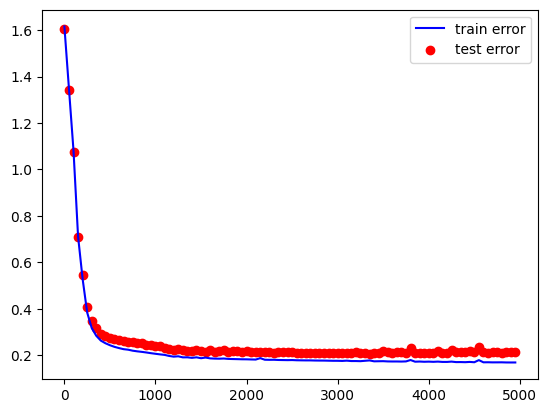

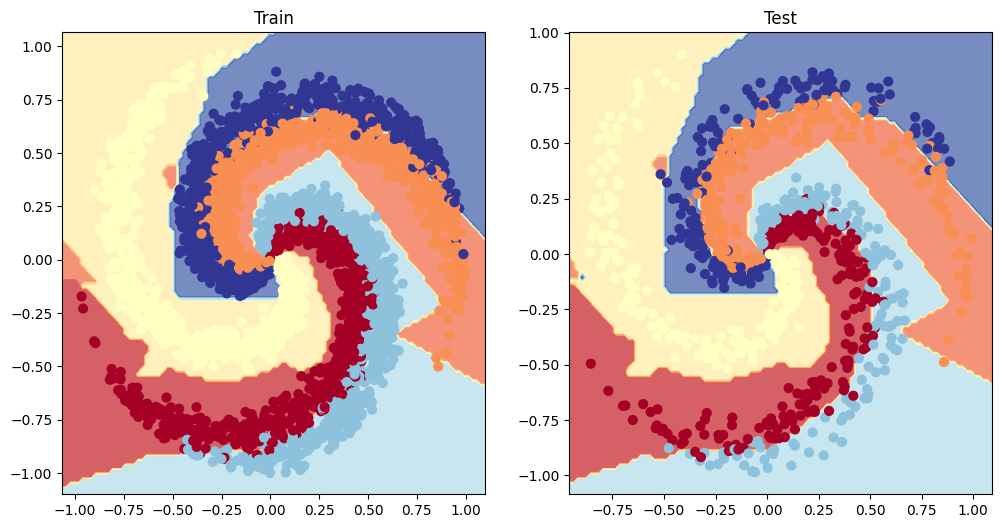

In [99]:
plt.plot(np.arange(0, 5000, 50), np.array(all_train_loss), c='b', label='train error')
plt.scatter(np.arange(0, 5000, 50), np.array(all_test_loss), c='r', label='test error')
plt.legend()
plt.show()

# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_5, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_5, X_test, y_test)